In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection , preprocessing
from six import StringIO
import matplotlib.colors as colors
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
#import pydotplus
import scipy
import itertools
import seaborn as sns
from iminuit import Minuit
from scipy import integrate
from scipy.stats import chi2
from scipy.special import erfinv

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import nn_utils
import dt_utils

## PART 1 - Data reading and plotting of data
Read in the data and plot the kinematic variables. The data will be examined and cuts made in order to make the signal peak more prominent on the reco_zv_mass plot

In [3]:
pd_top = pd.read_csv("Top.csv")
pd_diboson = pd.read_csv("Diboson.csv")
pd_gg = pd.read_csv("ggH1000.csv")
pd_Zj = pd.read_csv("Zjets.csv")

# pd_Zj.dropna(inplace = True)
# pd_top.dropna(inplace = True)
# pd_diboson.dropna(inplace = True)
# pd_gg.dropna(inplace = True)

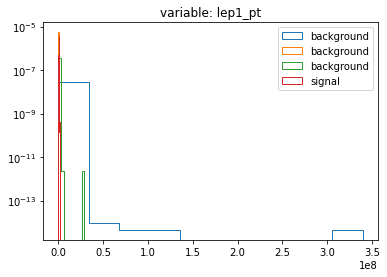

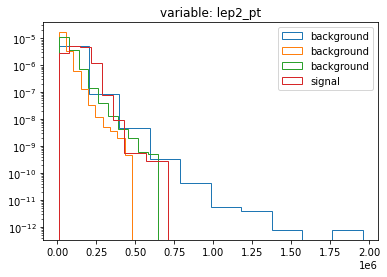

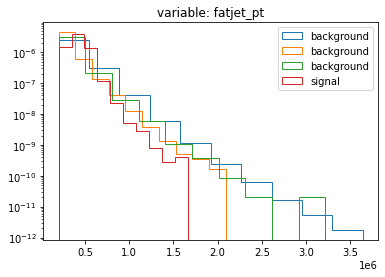

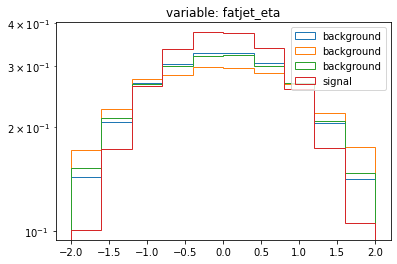

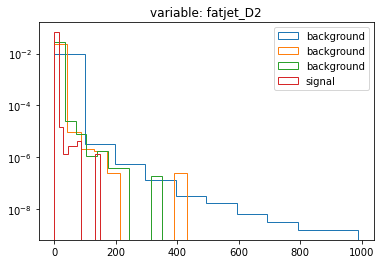

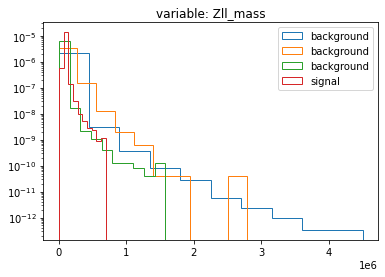

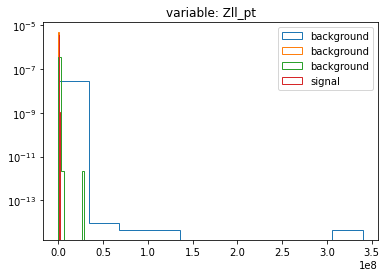

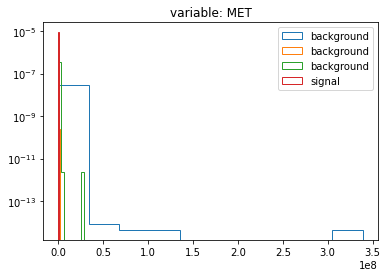

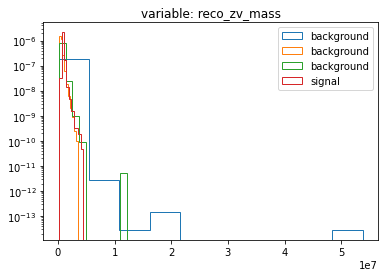

In [4]:
variables = ["lep1_pt","lep2_pt","fatjet_pt","fatjet_eta","fatjet_D2","Zll_mass","Zll_pt","MET","reco_zv_mass"]

for i in range(len(variables)):
    plt.hist(pd_Zj[variables[i]],density=True ,histtype='step',label="background")
    plt.hist(pd_top[variables[i]],density=True, histtype='step',label="background")
    plt.hist(pd_diboson[variables[i]],density=True, histtype='step',label="background")
    plt.hist(pd_gg[variables[i]],density=True,histtype='step',label="signal")
    plt.title(f"variable: {variables[i]}")
    plt.semilogy()
    plt.legend()
    plt.show()

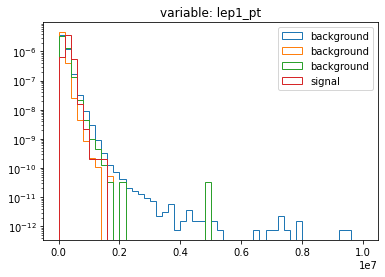

In [5]:
var = 'lep1_pt'
rang = (0,1e7)
plt.hist(pd_Zj[var],density=True ,histtype='step',label="background",range=rang,bins=50)
plt.hist(pd_top[var],density=True, histtype='step',label="background",range =rang,bins=50)
plt.hist(pd_diboson[var],density=True, histtype='step',label="background",range =rang,bins=50)
plt.hist(pd_gg[var],density=True,histtype='step',label="signal",range =rang,bins=50)
plt.title(f"variable: {var}")
plt.legend()
plt.semilogy()
plt.show()

### Deciding on Cuts to apply to the dataset. Sometime was spent on finding cuts, the graphs can be seen above however not all are shown because it took some trial and error

In [7]:
#apply cuts
lep1pt_Cut = 'lep1_pt > 1e5'
lep2pt_Cut = 'lep2_pt > 8e4'
Zllmass_Cut = 'Zll_mass < 2e5'
fjD2_Cut = 'fatjet_D2 < 40'

cut_diboson = pd_diboson.query(lep1pt_Cut)
cut_top = pd_top.query(lep1pt_Cut)
cut_Zj = pd_Zj.query(lep1pt_Cut)
cut_gg = pd_gg.query(lep1pt_Cut)

cut_diboson = cut_diboson.query(lep2pt_Cut)
cut_top = cut_top.query(lep2pt_Cut)
cut_Zj = cut_Zj.query(lep2pt_Cut)
cut_gg = cut_gg.query(lep2pt_Cut)

cut_diboson = cut_diboson.query(Zllmass_Cut)
cut_top = cut_top.query(Zllmass_Cut)
cut_Zj = cut_Zj.query(Zllmass_Cut)
cut_gg = cut_gg.query(Zllmass_Cut)

cut_diboson = cut_diboson.query(fjD2_Cut)
cut_top = cut_top.query(fjD2_Cut)
cut_Zj = cut_Zj.query(fjD2_Cut)
cut_gg = cut_gg.query(fjD2_Cut)

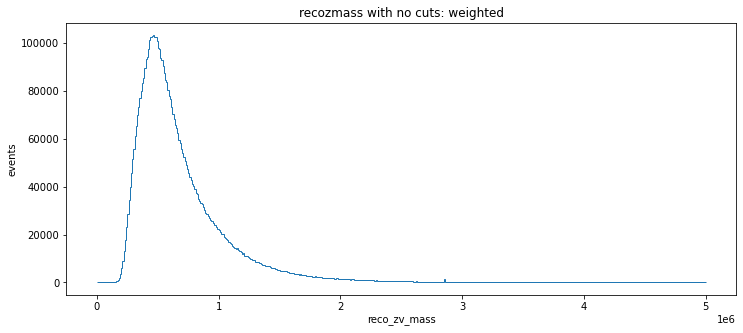

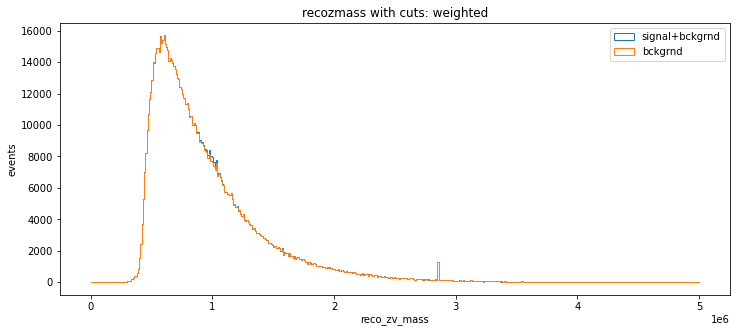

Total number of events for the preCut is:  27033713235.84636
Total number of events for the postCut is: 5066609341.235142


In [8]:
pd_total = pd.concat([pd_Zj, pd_top, pd_diboson, pd_gg])   # total df of all the data with no cuts
pd_bckgrnd = pd.concat([cut_Zj, cut_top, cut_diboson])
pd_signal = cut_gg
pd_cutsTotal = pd.concat([cut_Zj, cut_top, cut_diboson, cut_gg])   # total df of all the data with cuts

fig = plt.figure(figsize=(12,5))
n1,bins1,patches1 = plt.hist(pd_total["reco_zv_mass"], weights = pd_total["FullEventWeight"], bins=500,histtype='step',range = (0,5e6))
plt.title('recozmass with no cuts: weighted')
plt.xlabel("reco_zv_mass")
plt.ylabel("events")
# plt.xlim([0,3e6])
plt.show()


fig = plt.figure(figsize=(12,5))
n2,bins2,patches2 = plt.hist(pd_cutsTotal["reco_zv_mass"], weights = pd_cutsTotal["FullEventWeight"], bins=500,histtype='step',range = (0,5e6),label="signal+bckgrnd")
plt.hist(pd_bckgrnd["reco_zv_mass"], weights = pd_bckgrnd["FullEventWeight"], bins=500,histtype='step',range = (0,5e6),label="bckgrnd")
plt.title('recozmass with cuts: weighted')
plt.xlabel("reco_zv_mass")
plt.ylabel("events")
plt.legend()
# plt.xlim([0,3e6])
plt.show()


bin_width1 = (bins1[1] - bins1[0])/2
integral1 = np.sum(n1)*bin_width1

bin_width2 = (bins2[1] - bins2[0])/2
integral2 = np.sum(n2)*bin_width2

print(f"Total number of events for the preCut is:  {integral1}")
print(f"Total number of events for the postCut is: {integral2}")

The cuts can be seen to reduce number of events by roughly a factor of 5, most of which would be background so that is a huge amount. It will definitely be helpful when it comes to fitting

## PART 2 Fitting of functions
Beginning with fitting the reco_zv_mass spectrums for the background and signal seperately
The class is taken from one of the previous checkpoints and altered slightly to meet the requirements here. It will be able to fit gaussian, polynomial and conjugate functions using a chi_sq technique

In [9]:
class Fitter:
    def __init__(self,N,binedges,mu,sigma):   # mu sigma included only for the case of conjugate function
        self.N = N
        self.binedges = binedges
        self.mu = mu
        self.sigma = sigma
        
    def Gauss(self,t,mu,sigma):
        norm = np.sqrt(2*np.pi*sigma**2) # the normalising factor of Gaussian between 0,inf -fair assumption
        val = (1/norm)*np.exp(-(t-mu)**2/(2*sigma**2))
        return val
        
    def Poly(self,t,a,b,c):
        norm = a*600e3 + b*660e9 + 744e15*c   # the normalising factor of 2nd order polynomial between 0.8,1.4
        val = (1/norm) * (a + b*t + c*(t**2))
#         val[val<=0] = 0.000001
        return val
    
    def Conj(self,t,a,b,c,frac=1):  # combines polynomial and gaussian functions 
        poly = frac*(self.Poly(t,a,b,c))
        gauss = (1-frac)*(self.Gauss(t,self.mu,self.sigma))
        return poly + gauss
    
    def integral_P(self,limit1,limit2,a,b,c):
        return integrate.quad(self.Poly,limit1,limit2,args=(a,b,c))[0]

    def integral_G(self,limit1,limit2,mu,sigma):
        return integrate.quad(self.Gauss,limit1,limit2,args=(mu,sigma))[0]
    
    def integral_C(self,limit1,limit2,a,b,c,frac):
        return integrate.quad(self.Conj,limit1,limit2,args=(a,b,c,frac))[0]
    
    def chi_square_conj(self,a,b,c,frac=1):  # chi_sq function for conjugate function
        expected = np.zeros(len(self.N))
        for i in range(len(self.N)):
            limit1 = self.binedges[i]
            limit2 = self.binedges[i+1]

            expected[i] = self.integral_C(limit1,limit2,a,b,c,frac)
        expected *= np.sum(self.N)
#         self.N[self.N<=0] = 1e-3
        expected[expected<=0] = 1e-3
        
        Chi2 = 2*np.sum(expected - self.N + self.N*np.log(self.N/expected))
        return Chi2
    
    def chi_square_poly(self,a,b,c):  # chi_sq function for polynomial function
        expected = np.zeros(len(self.N))
        for i in range(len(self.N)):
            limit1 = self.binedges[i]
            limit2 = self.binedges[i+1]

            expected[i] = self.integral_P(limit1,limit2,a,b,c)
        expected *= np.sum(self.N)
#         self.N[self.N<=0] = 1e-3
        expected[expected<=0] = 1e-3
        
        Chi2 = 2*np.sum(expected - self.N + self.N*np.log(self.N/expected))
        return Chi2
    
    def chi_square_gauss(self,mu,sigma):  # chi_sq function for gaussian function
        expected = np.zeros(len(self.N))
        for i in range(len(self.N)):
            limit1 = self.binedges[i]
            limit2 = self.binedges[i+1]

            expected[i] = self.integral_G(limit1,limit2,mu,sigma)
        expected[np.isnan(expected)] = 0
        expected *= np.sum(self.N)
        self.N[self.N<=0] = 1e-3
        expected[expected<=0] = 1e-3
        
        Chi2 = 2*np.sum(expected - self.N + self.N*np.log(self.N/expected))
        return Chi2

    
    def chi(parameters,y,x):
        expected = (self.Conj(x,*parameters))
        y[y<=0] = 1e-3
        expected[expected<=0] = 1e-3

        Chi2 = 2*np.sum(expected - y + y*np.log(y/expected))

        return Chi2

### Fitting a gaussian to the signal peak

It was found that reducing the data to the window of 0.85e6 - 1.15e6 increased the accuracy of the fit. The excess data was causing it to flatten so the fit was taken with these cuts applied

<ValueView mu=992580.2671183668 sigma=39861.78492620157>


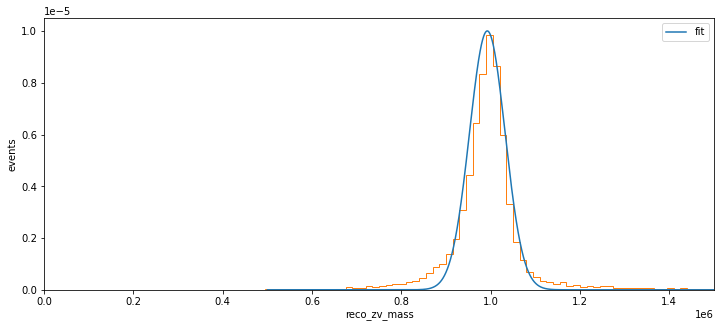

In [10]:
fig = plt.figure(figsize=(12,5))
nsig,binsig,patchesig = plt.hist(pd_signal["reco_zv_mass"], weights = pd_signal["FullEventWeight"], bins=50,histtype='step',range=(0.9e6,1.1e6))
plt.title('recozmass: signal')
plt.xlabel("reco_zv_mass")
plt.ylabel("events")
plt.close()
# plt.show()

df_gauss= Fitter(nsig,binsig,0,0)

start_exp = {"mu":1e6,"sigma":5e4}     # Initial guesses to pass to minuit
mG = Minuit(df_gauss.chi_square_gauss,**start_exp) # Run the Minuit minimiser to get a fit
mG.errordef = Minuit.LIKELIHOOD
mG.migrad()

print(mG.values)
x = np.linspace(0.5e6,1.5e6,5000)
y = df_gauss.Gauss(x,*mG.values)
fig = plt.figure(figsize=(12,5))
plt.plot(x,y,label="fit")
plt.hist(pd_signal["reco_zv_mass"], weights = pd_signal["FullEventWeight"], bins=200,histtype='step',range=(0,3e6),density=True)
# plt.hist(data_sig,bins=200,density=True,label="data")
plt.xlabel("reco_zv_mass")
plt.ylabel("events")
plt.xlim(0,1.5e6)
plt.legend()
plt.show()

The fit looks very good, the range had to be chopped down by quite a bit because excess data was clouding the fits ability to do its job, but once that was done the signal looks well represented by the gaussian fit

### Fitting a polynomial to the background data

<ValueView a=2949.986065121343 b=-0.003133904128031643 c=8.68162869293256e-10>


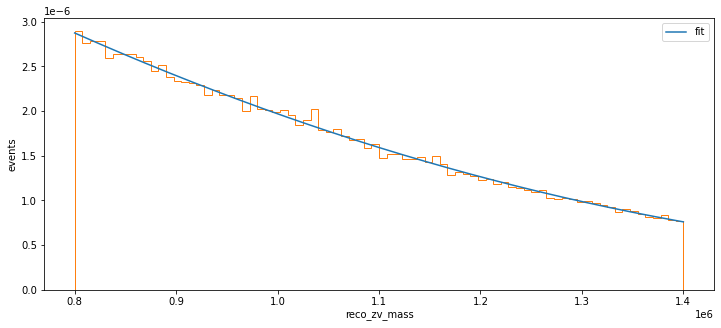

In [11]:
fig = plt.figure(figsize=(12,5))
nbck,binsbck,patchesbck = plt.hist(pd_bckgrnd["reco_zv_mass"], weights = pd_bckgrnd["FullEventWeight"], bins=80,histtype='step',range=(0.8e6,1.4e6))
plt.title('recozmass: background)')
plt.xlabel("reco_zv_mass")
plt.ylabel("events")
plt.close()

df_poly = Fitter(nbck,binsbck,0,0)

start_exp = {"a":6e4,"b":-0.0025,"c":0}     # Initial guesses to pass to minuit
mP = Minuit(df_poly.chi_square_poly,**start_exp) # Run the Minuit minimiser to get a fit
mP.errordef = Minuit.LIKELIHOOD
mP.migrad()
print(mP.values)

x = np.linspace(0.8e6,1.4e6,5000)
y = df_poly.Poly(x,*mP.values)
fig = plt.figure(figsize=(12,5))
plt.plot(x,y,label="fit")
plt.hist(pd_bckgrnd["reco_zv_mass"], weights = pd_bckgrnd["FullEventWeight"], bins=80,histtype='step',range=(0.8e6,1.4e6),density=True)
# plt.hist(data_sig,bins=200,density=True,label="data")
plt.xlabel("reco_zv_mass")
plt.ylabel("events")
# plt.xlim(0,1.5e6)
plt.legend()
plt.show()

The Fit looks very good, it has converged nicely using the polynomial distribution

### Fitting a conjugate function with H0 and H1 hypothesis then calculating the statistical significance

H0 hypothesis parameters are:
 <ValueView a=18056.631947897753 b=-0.018860948497887994 c=5.082817552602434e-09>


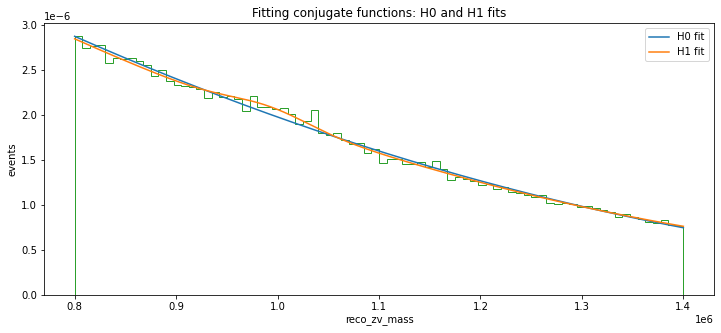

H1 hypothesis parameters are:
 <ValueView a=29444.317398184943 b=-0.031622577889267575 c=8.90942979381825e-09 frac=0.9883260981929185>


In [13]:
fig = plt.figure(figsize=(12,5))
nP,binsP,patchesP = plt.hist(pd_cutsTotal["reco_zv_mass"], weights = pd_cutsTotal["FullEventWeight"], bins=80,histtype='step',range=(0.8e6,1.4e6))
plt.title('recozmass: background)')
plt.xlabel("reco_zv_mass")
plt.ylabel("events")
plt.close()
# plt.show()

df_h0 = Fitter(nP,binsP,mG.values[0],mG.values[1])  # initiaslising the class

"""
THE H0 hypothesis is given below
"""

start_exp = {"a":6e4,"b":-0.025,"c":0}     # Initial guesses to pass to minuit
mH0 = Minuit(df_h0.chi_square_poly,**start_exp) # Run the Minuit minimiser to get a fit
mH0.errordef = Minuit.LIKELIHOOD
mH0.migrad()


x = np.linspace(0.8e6,1.4e6,5000)
y0 = df_h0.Poly(x,*mH0.values)

print(f"H0 hypothesis parameters are:\n {mH0.values}")

# df_h1 = Fitter(data_final,nP,binsP,mG.values[0],mG.values[1])  # initiaslising the class

"""
THE H1 hypothesis fit is given below
"""
start_exp = {"a":6e4,"b":-0.025,"c":0,"frac":0.9}     # Initial guesses to pass to minuit
mH1 = Minuit(df_h0.chi_square_conj,**start_exp) # Run the Minuit minimiser to get a fit
mH1.errordef = Minuit.LIKELIHOOD
mH1.migrad()


x = np.linspace(0.8e6,1.4e6,5000)
y1 = df_h0.Conj(x,*mH1.values)
fig = plt.figure(figsize=(12,5))
plt.plot(x,y0,label="H0 fit")
plt.plot(x,y1,label="H1 fit")
plt.hist(pd_cutsTotal["reco_zv_mass"], weights = pd_cutsTotal["FullEventWeight"], bins=80,histtype='step',range=(0.8e6,1.4e6),density=True)
plt.title("Fitting conjugate functions: H0 and H1 fits")
plt.xlabel("reco_zv_mass")
plt.ylabel("events")
# plt.xlim(0,1.5e6)
plt.legend()
plt.show()

print(f"H1 hypothesis parameters are:\n {mH1.values}")

The fits do well to converge, the H1 fit finds the little bump in the data which is almost imperceptible to the eye, but it clearly is able to get to it. The H0 fit looks pretty clean as well.

### Z score will be calculated to find statistical significance of H1 hypothesis. Significance of the signal peak in the background data

In [14]:
def chi(parameters,y,x):
        expected = (df_h0.Conj(x,*parameters))
        y[y<=0] = 1e-3
        expected[expected<=0] = 1e-3

        Chi2 = 2*np.sum(expected - y + y*np.log(y/expected))

        return Chi2

x = np.linspace(0.8e6,1.4e6,len(nP))

chi0 = chi(mH0.values,nP,x)
chi1 = chi(mH1.values,nP,x)

print(chi0-chi1)
"""
Zscore will be calculated to see the statistical significance 
"""

chi2_H0 = df_h0.chi_square_poly(*mH0.values)
chi2_H1 = df_h0.chi_square_conj(*mH1.values)
# print(chi2_H0-chi2_H1)
deltaChi = chi0-chi1
Ndof = 1
pval = chi2.cdf(deltaChi,Ndof)
Zscore = erfinv(1-pval) * np.sqrt(2)
print(f"P Value: {pval}")
print(f"Zscore is: {Zscore}")
# print(deltaChi)

85.26220020651817
P Value: 1.0
Zscore is: 0.0


Sometimes the Pvalue gets rounded up to 1 and the Zscore thus rounded to 0 but sometimes it is around 1e-13 for the zscore.


It can be seen that both fits are good however the difference in chi^2 is a lot so this gives a very high P value and then a very low Zscore. I think this makes sense based off the fact the deviation is so very small the z score you would not expect to be very large - the difference between the two fits is so minute so probability of type 1 error should be massive. The pvalue is the probability of the H0 hypothesis giving the observed data or type 1 error in this case since we know H1 hypothesis to be true. In this scenario it makes sense since the deviation is so small. So in this scenario you cannot rule out a null hypothesis since it is so likely for the H0 to give something resembling the H1.
The Zscore therefore also makes a lot of sense the statistical significance is very very small since null hypothesis cannot be ruled out

# PART 3 - Employing a NN classifier

Creating the dataframes with data admixture ready for NN

In [15]:
pd_mega = pd.concat([pd_top,pd_Zj,pd_diboson],ignore_index=True)  # concatenate all the background datasets together

pd_mega = sklearn.utils.shuffle(pd_mega,random_state = 1)    # shuffle the dataset with random seed
pd_mega = pd_mega.reset_index(drop=True)

pd_bck_sig = pd.concat([pd_mega[0:pd_gg.shape[0]],pd_gg],) # creates 50:50 admixture of signal and bckground

pd_bck_sig = sklearn.utils.shuffle(pd_bck_sig,random_state = 1)
pd_bck_sig = pd_bck_sig.reset_index(drop=True)

new_features = ["lep1_pt","lep2_pt","fatjet_pt","fatjet_eta","fatjet_D2","Zll_mass","Zll_pt","MET","reco_zv_mass"] #for use later on
features = ["lep1_pt","lep2_pt","fatjet_pt","fatjet_eta","fatjet_D2","Zll_mass","Zll_pt","MET"]
target = ["isSignal"]

pdA = pd_bck_sig[features+target]
pdB = pd_bck_sig[new_features+target]  #for later on
pdFull_dataset = pd.concat([pd_mega,pd_gg],ignore_index=True)

Creating trainging and testing data preprocessing the data

In [16]:
sc = preprocessing.StandardScaler()
input_data = sc.fit_transform(pdA[features])
target_data =  pdA[target].values
# set random seed
Answer_to_all_questions = 42
# train - test split of dataset
train_data, test_data, train_target, test_target = model_selection.train_test_split (\
input_data , target_data, test_size =0.3, random_state = Answer_to_all_questions)

print (train_data.shape,train_target.shape,test_data.shape, test_target.shape )

(70018, 8) (70018, 1) (30008, 8) (30008, 1)


Creating the NN model which will attempt to categorise the data. A dense model with activation relu is used

In [17]:
def my_model(num_inputs , num_nodes , extra_depth ):
    num_outputs = 1
    
    # create model
    model = Sequential()
    model.add(Dense(num_nodes,input_dim = num_inputs , kernel_initializer ="normal",activation ="relu"))
    model.add(Dropout(0.2))
    for i in range (extra_depth):
        model.add(Dense(num_nodes,input_dim = num_nodes,kernel_initializer ="normal",activation ="relu"))
        model.add(Dropout(0.2))
    
    
    
    model.add(Dense(num_outputs,activation ="sigmoid"))
    # Compile model
    model.compile(loss ="binary_crossentropy", optimizer ="adam", metrics =["accuracy"])
    return model

Run the model on the data for 50 epochs and 500 batchsize

In [18]:
batchSize = 500
N_epochs = 50
model1 = my_model(8,20,1)
history = model1.fit(train_data,train_target,batch_size = batchSize,epochs = N_epochs,verbose =1 ,validation_data =(test_data,test_target))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 70018 samples, validate on 30008 samples
Epoch 1/50
70018/70018 [==============================] - 1s 16us/sample - loss: 0.4863 - acc: 0.8408 - val_loss: 0.3321 - val_acc: 0.8727
Epoch 2/50
70018/70018 [==============================] - 1s 9us/sample - loss: 0.3264 - acc: 0.8759 - val_loss: 0.2947 - val_acc: 0.8852
Epoch 3/50
70018/70018 [==============================] - 1s 9us/sample - loss: 0.3067 - acc: 0.8815 - val_loss: 0.2847 - val_acc: 0.8880
Epoch 4/50
70018/70018 [==============================] - 1s 11us/sample - loss: 0.3019 - acc: 0.8830 - val_loss: 0.2816 - val_acc: 0.8894
Epoch 5/50
70018/70018 [==============================] - 1s 9us/s

Plot the loss and accuracy curves against epochs to understand the fit abit better

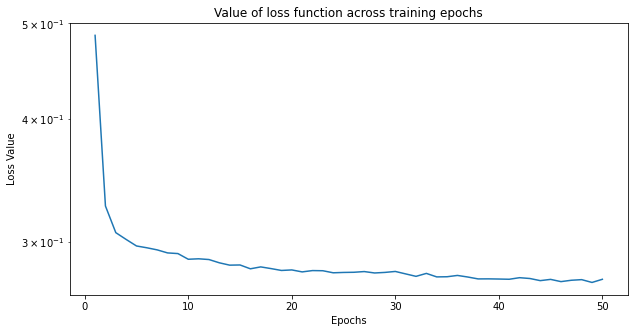

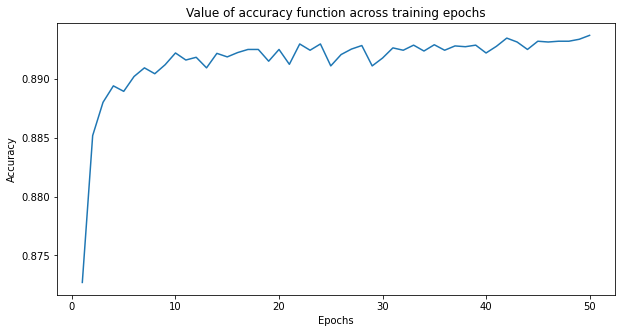

In [19]:
plt.figure(figsize=(10.0, 5.0))
epochs = np.arange(1,51)

plt.plot(epochs,history.history["loss"])
plt.title('Value of loss function across training epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.semilogy()
plt.show()

plt.figure(figsize=(10.0, 5.0))
plt.plot(epochs,history.history["val_acc"])
plt.title('Value of accuracy function across training epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

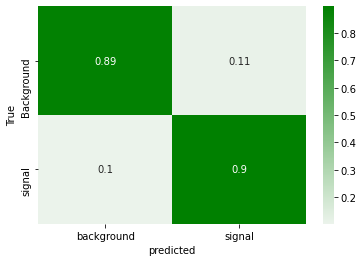

In [20]:
nn_pred = model1.predict(test_data)
predicted = nn_pred>0.5

nn_cm = sklearn.metrics.confusion_matrix(test_target, predicted)
labels = ["predicted","True"]
classes = [["background","signal"],["Background","signal"]]
dt_utils.heatmap(d = nn_cm,labels = labels, classes = classes,normalize= True)

The graphs show the NN converges after roughly 20 epochs and not much progress is achieved thereafter, the accuracy ends at roughly 0.9 and we see this confirmed with the confusion matrix

### The NN is applied to the full dataset after cuts have been applied to try and reduce background even further. All events with probability <0.5 are rejected to reduce the signal background ratio further

In [21]:
"""
THese are the datasets with and without original square cuts so the NN model will be applied on these two and differences noted

pd_cutsTotal
pdFull_dataset
""" 

input_full = sc.fit_transform(pdFull_dataset[features])
input_cut = sc.fit_transform(pd_cutsTotal[features])

full_pred = model1.predict(input_full)
cut_pred = model1.predict(input_cut)

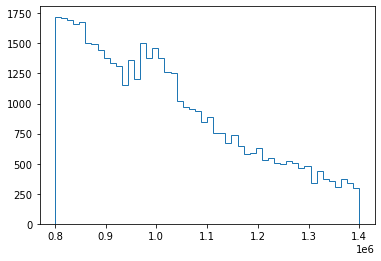

In [22]:
# test =   pdFull_dataset["reco_zv_mass"].values

pdFull_dataset["pred"] = pd.DataFrame(full_pred,columns=["pred"])
pd_cutsTotal["pred"] = pd.DataFrame(cut_pred,columns=["pred"])

N_nn,binedges_nn,patches = plt.hist(pd_cutsTotal["reco_zv_mass"][pd_cutsTotal.pred<0.5], weights = pd_cutsTotal["FullEventWeight"][pd_cutsTotal.pred<0.5], bins=50,histtype='step',range=(0.8e6,1.4e6))
# N_nn,binedges_nn,patches = plt.hist(pdFull_dataset["reco_zv_mass"][pdFull_dataset.pred>0.5], weights = pdFull_dataset["FullEventWeight"][pdFull_dataset.pred>0.5], bins=50,histtype='step',range=(0.8e6,1.4e6))


The NN does amazingly in cutting a lot of background and now the signal can be seen clearly peaking out of the spectrum. It has done its job and should therefore be alot easier to fit this data and find a H1 hypothesis is statistically significant.

## Now the process of H0 and H1 fitting is done again but with the data from the NN

H0 hypothesis parameters are:
 <ValueView a=46001.53082388427 b=-0.02348530700477584 c=-2.033632854587193e-09>


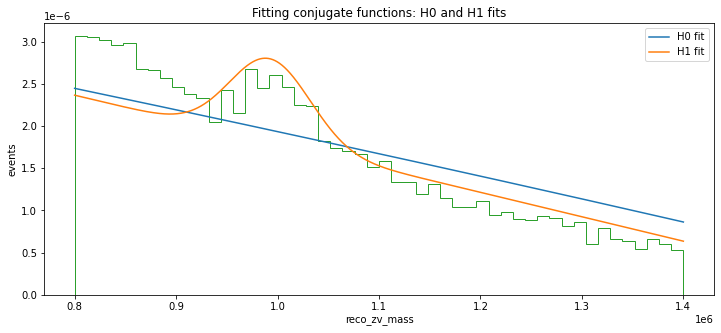

H1 hypothesis parameters are:
 <ValueView a=42001.540108136556 b=-0.02554353095531013 c=-2.497833772238921e-10 frac=0.9015855768102264>
2.346865797160476e-06

P Value: 0.001222317471354798
Zscore is: 3.2336205283753716


In [24]:
df_NN = Fitter(N_nn,binedges_nn,mG.values[0],mG.values[1])  # initiaslising the class

"""
THE H0 hypothesis is given below
"""

start_exp = {"a":6e4,"b":-0.025,"c":0}     # Initial guesses to pass to minuit
mNN_H0 = Minuit(df_NN.chi_square_poly,**start_exp) # Run the Minuit minimiser to get a fit
mNN_H0.errordef = Minuit.LIKELIHOOD
mNN_H0.migrad()


x = np.linspace(0.8e6,1.4e6,5000)
y0 = df_h0.Poly(x,*mNN_H0.values)

print(f"H0 hypothesis parameters are:\n {mNN_H0.values}")

# df_h1 = Fitter(data_final,nP,binsP,mG.values[0],mG.values[1])  # initiaslising the class

"""
THE H1 hypothesis fit is given below
"""
start_exp = {"a":6e4,"b":-0.025,"c":0,"frac":0.9}     # Initial guesses to pass to minuit
mNN_H1 = Minuit(df_NN.chi_square_conj,**start_exp) # Run the Minuit minimiser to get a fit
mNN_H1.errordef = Minuit.LIKELIHOOD
mNN_H1.migrad()


x = np.linspace(0.8e6,1.4e6,5000)
y1 = df_NN.Conj(x,*mNN_H1.values)
fig = plt.figure(figsize=(12,5))
plt.plot(x,y0,label="H0 fit")
plt.plot(x,y1,label="H1 fit")
N_nn,binedges_nn,patches = plt.hist(pd_cutsTotal["reco_zv_mass"][pd_cutsTotal.pred<0.5], weights = pd_cutsTotal["FullEventWeight"][pd_cutsTotal.pred<0.5], bins=50,histtype='step',range=(0.8e6,1.4e6),density=True)
plt.title("Fitting conjugate functions: H0 and H1 fits")
plt.xlabel("reco_zv_mass")
plt.ylabel("events")
# plt.xlim(0,1.5e6)
plt.legend()
plt.show()

print(f"H1 hypothesis parameters are:\n {mNN_H1.values}")

x = np.linspace(0.8e6,1.4e6,len(N_nn))

chi0 = chi(mNN_H0.values,N_nn,x)
chi1 = chi(mNN_H1.values,N_nn,x)

print(chi0-chi1)
"""
Zscore will be calculated to see the statistical significance 
"""

chi2_H0 = df_NN.chi_square_poly(*mNN_H0.values)
chi2_H1 = df_NN.chi_square_conj(*mNN_H1.values)
# print(chi2_H0-chi2_H1)
deltaChi = chi0-chi1
Ndof = 1
pval = chi2.cdf(deltaChi,Ndof)
Zscore = erfinv(1-pval) * np.sqrt(2)
print(f"\nP Value: {pval}")
print(f"Zscore is: {Zscore}")
# print(deltaChi)

So Both fits look pretty good but the H1 fit clearly does a decent job of modelling the bump in the graph. pvalue is now very small which is the likelihood of a H0 hypothesis giving the observed data or the probability of a type 1 error. This makes sense since the bump is now extremely large and so it would be odd for a polynomial distibution to produce such a large disturbance from the background purely from chance. The Zscore is therefore high at 3.4, this would be strong evidence of differing physics from the background, very statistically significant which makes a lot of sense since the bump is very clear and the H1 fit is very good.

# PART 4 - incorporating the reco_zv_mass into the NN

A new NN model is made with the added feature of reco_zv_mass, this is copied from above and changed slightly for this new purpose, confusion matrix is plot and then the spectrums plot at the bottom

In [25]:
new_features =  ["lep1_pt","lep2_pt","fatjet_pt","fatjet_eta","fatjet_D2","Zll_mass","Zll_pt","MET","reco_zv_mass"]

input_data2 = sc.fit_transform(pdB[new_features])
target_data2 =  pdB[target].values
# set random seed
Answer_to_all_questions = 42
# train - test split of dataset
train_data2, test_data2, train_target2, test_target2 = model_selection.train_test_split (\
input_data2 , target_data2, test_size =0.3, random_state = Answer_to_all_questions)

print (train_data2.shape,train_target2.shape,test_data2.shape, test_target2.shape )

(70018, 9) (70018, 1) (30008, 9) (30008, 1)


Train on 70018 samples, validate on 30008 samples
Epoch 1/50
70018/70018 [==============================] - 1s 16us/sample - loss: 0.4612 - acc: 0.8630 - val_loss: 0.2979 - val_acc: 0.8888
Epoch 2/50
70018/70018 [==============================] - 1s 10us/sample - loss: 0.2802 - acc: 0.8941 - val_loss: 0.2444 - val_acc: 0.9068
Epoch 3/50
70018/70018 [==============================] - 1s 15us/sample - loss: 0.2432 - acc: 0.9095 - val_loss: 0.2168 - val_acc: 0.9208
Epoch 4/50
70018/70018 [==============================] - 1s 18us/sample - loss: 0.2244 - acc: 0.9206 - val_loss: 0.2035 - val_acc: 0.9277
Epoch 5/50
70018/70018 [==============================] - 1s 10us/sample - loss: 0.2133 - acc: 0.9263 - val_loss: 0.1952 - val_acc: 0.9311
Epoch 6/50
70018/70018 [==============================] - 1s 10us/sample - loss: 0.2071 - acc: 0.9291 - val_loss: 0.1910 - val_acc: 0.9319
Epoch 7/50
70018/70018 [==============================] - ETA: 0s - loss: 0.2030 - acc: 0.930 - 1s 9us/sample - loss

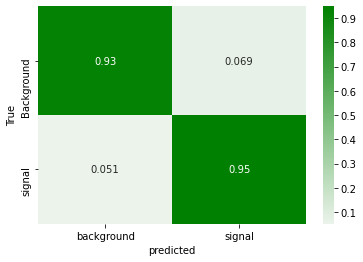

In [26]:
batchSize = 500
N_epochs = 50
model2 = my_model(9,20,1)
history = model2.fit(train_data2,train_target2,batch_size = batchSize,epochs = N_epochs,verbose =1 ,validation_data =(test_data2,test_target2))

nn_pred2 = model2.predict(test_data2)
predicted2 = nn_pred2>0.5

nn_cm = sklearn.metrics.confusion_matrix(test_target2, predicted2)
labels = ["predicted","True"]
classes = [["background","signal"],["Background","signal"]]
dt_utils.heatmap(d = nn_cm,labels = labels, classes = classes,normalize= True)

In [27]:
input_full = sc.fit_transform(pdFull_dataset[new_features])
input_cut = sc.fit_transform(pd_cutsTotal[new_features])

full_pred2 = model2.predict(input_full)
cut_pred2 = model2.predict(input_cut)

pdFull_dataset["pred2"] = pd.DataFrame(full_pred2,columns=["pred2"])
pd_cutsTotal["pred2"] = pd.DataFrame(cut_pred2,columns=["pred2"])

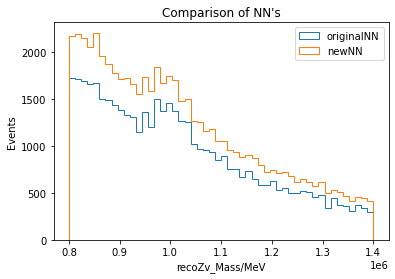

In [28]:
N_nn,binedges_nn,patches = plt.hist(pd_cutsTotal["reco_zv_mass"][pd_cutsTotal.pred<0.5], weights = pd_cutsTotal["FullEventWeight"][pd_cutsTotal.pred<0.5], bins=50,histtype='step',range=(0.8e6,1.4e6),label="originalNN")
N_nn2,binedges_nn2,patches2 = plt.hist(pd_cutsTotal["reco_zv_mass"][pd_cutsTotal.pred2<0.5], weights = pd_cutsTotal["FullEventWeight"][pd_cutsTotal.pred2<0.5], bins=50,histtype='step',range=(0.8e6,1.4e6),label="newNN")
plt.legend()
plt.title("Comparison of NN's")
plt.xlabel("recoZv_Mass/MeV")
plt.ylabel("Events")
plt.show()

The difference between the two Neural Nets can be seen above on the graph. In both, the signal is clear above the background and I wouldn't say either is more or less defined, the new NN clearly doesn't cut as much data since it sits slightly higher on the graph and whether this is significant is hard to say. The model itself is more accurate reaching a level of about 94%, about a 4 percent increase on the previous NN. It should do better at cutting however perhaps the first NN was sufficiently good that there wasn't much to improve on and so it is hard to see a big difference.